In [1]:
import specpy
import numpy as np
from collections import deque
from skimage import measure
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

a = specpy.get_application()

120
390


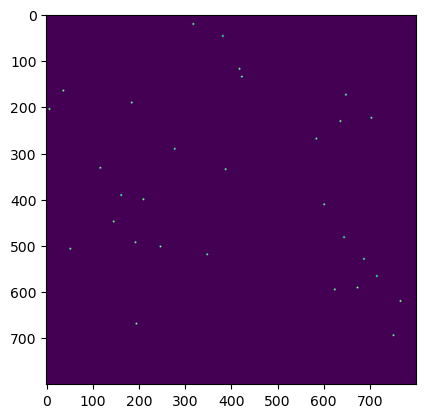

In [132]:
meas = a.active_measurement()
meas.activate(meas.configuration('ov conf'))
#data_conf = meas.stack(0).data()
meas.create_stack(int, np.roll(np.shape(meas.stack(0).data()),2))
#nst = meas.number_of_stacks()
data = meas.stack(meas.number_of_stacks()-1).data()
stack = meas.stack(meas.number_of_stacks()-1)

# small peaks
x_event = np.random.randint(0,799,(30))
y_event = np.random.randint(0,799,(30))
for x,y in zip(x_event, y_event):
    data[0,0,y,x] = 4
print(np.sum(np.sum(data[0,0])))
kernel = [[False, True, False],[ True, True,  True],[False, True, False]]
for i in range(2):
    data[0,0] = ndi.binary_dilation(data[0,0], kernel)
stack.set_name('hey')
print(np.sum(np.sum(data[0,0])))
plt.imshow(data[0,0])
plt.show()


In [101]:
meas.create_stack(int, [800,800,1,1])
imst = specpy.Stack(event_image)
data = meas.stack(6).data()
print(imst)
print(meas.stack(6).data())
data[0,0,100,500] = 100
print(meas.stack(6).data())
print(event_image)

RuntimeError: Internal error: Measurement already closed.

In [128]:
cfg = meas.active_configuration()
cfg.

AttributeError: 'specpy.Configuration' object has no attribute 'close'

In [17]:
a.value_at('Minflux/tag', specpy.ValueTree.Measurement).set('ROI2')

In [32]:
meas = a.active_measurement()
img = meas.stack(5).data()
print(np.shape(img))

(1, 1, 120, 118)


In [1]:
import specpy
dir(specpy)
help(specpy)

Help on package specpy:

NAME
    specpy

PACKAGE CONTENTS
    _specpy
    specpy
    version

CLASSES
    builtins.SwigPyObject(builtins.object)
        DeviceStatus
        Error
        File
        Folder
        HardwareStatus
        HookRegistrationFlags
        IsConvertible
            Future
            Object
                Application
                Configuration
                Device
                Measurement
                Stack
            Promise
        Log
        MeasurementFlags
        MeasurementGuiLock
        MeasurementGuiLockFlags
        MeasurementResult
        MeasurementSignal
        MeasurementStartFlags
        Minflux
        Query
        Value
        ValueMode
        ValueNotification
        ValueNotifyReason
        ValueTree
    
    class Application(Object)
     |  Remote::Application
     |  
     |  Method resolution order:
     |      Application
     |      Object
     |      IsConvertible
     |      builtins.SwigPyObject
     |   

In [6]:
import specpy
import numpy as np
import matplotlib.pyplot as plt

ims = specpy.get_application()

stack 0: shape (1, 1, 800, 800)
stack 1: shape (1, 1, 1000, 1000)
stack 2: shape (1, 1, 800, 800)
stack 3: shape (1, 1, 1000, 1000)
stack 4: shape (1, 1, 1000, 1000)
(800, 800)


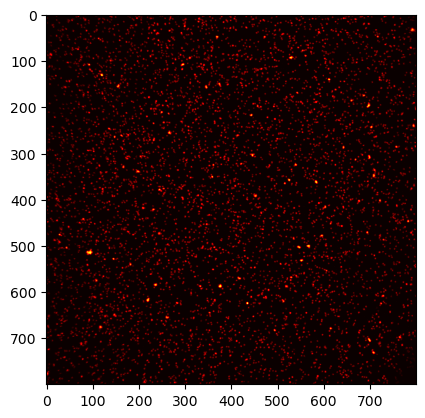

In [62]:
meas = ims.active_measurement()
for i in range(5):
    img_raw = meas.stack(i).data()
    print(f'stack {i}: shape {np.shape(img_raw)}')

img_raw = np.squeeze(meas.stack(0).data())
print(np.shape(img_raw))
plt.imshow(img_raw, cmap='hot')

[515  94]
[16, 18]

[588 376]
[14, 14]

[618 220]
[15, 13]

[501 567]
[13, 13]

[197 697]
[16, 13]

[363 584]
[14, 14]

[ 94 529]
[14, 21]

[131 120]
[20, 24]



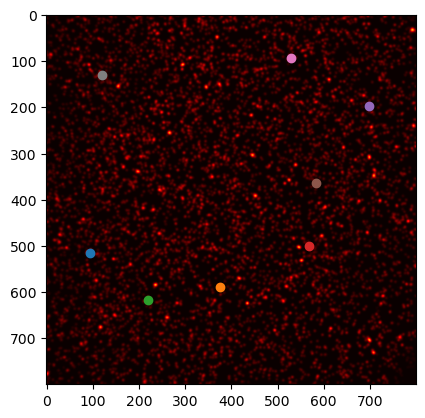

In [110]:
prev_frames=None
testmode=False
exinfo=None
min_dist=30
thresh_abs=30
num_peaks=30
smoothing_radius=2
border_limit=15
init_smooth=1

img = np.array(img_raw).astype('float32')
prev_frame = np.zeros(np.shape(img)).astype('float32')

if init_smooth==1:
    img = ndi.gaussian_filter(img, smoothing_radius)
    prev_frame = ndi.gaussian_filter(prev_frame, smoothing_radius)

img_ana = img

# Peak_local_max as a combo of opencv and numpy
size = int(2 * min_dist + 1)
img_ana = np.clip(img_ana, a_min=0, a_max=None)
img_ana = img_ana.astype('float32')
# get filter structuring element
footprint = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=[size,size])
# maximum filter (dilation + equal)
image_max = cv2.dilate(img_ana, kernel=footprint)
mask = np.equal(img_ana, np.array(image_max))
mask &= np.greater(img_ana, thresh_abs)

# get coordinates of peaks
coordinates = np.nonzero(mask)
intensities = img_ana[coordinates]
# highest peak first
idx_maxsort = np.argsort(-intensities)
coordinates = tuple(arr for arr in coordinates)
coordinates = np.transpose(coordinates)[idx_maxsort]

# remove everything on the border (takes ~2-3ms if there are a lot of detected coordinates, but usually this is not the case)
imsize = np.shape(img)[0]
idxremove = []
for idx, coordpair in enumerate(coordinates):
    if coordpair[0] < border_limit or coordpair[0] > imsize - border_limit or coordpair[1] < border_limit or coordpair[1] > imsize - border_limit:
        idxremove.append(idx)
coordinates = np.delete(coordinates,idxremove,axis=0)

# remove everyhting down to a certain length
if len(coordinates) > num_peaks:
    coordinates = coordinates[:int(num_peaks),:]

# roi size calculation
roi_sizes = []
cut_size = 50
roi_border = 3
for coords in coordinates:
    img_cut = img[coords[0]-int(cut_size/2):coords[0]+int(cut_size/2), coords[1]-int(cut_size/2):coords[1]+int(cut_size/2)]
    peak_val = img[coords[0],coords[1]]
    img_cut_mask = img_cut > peak_val/6
    labels_mask = measure.label(img_cut_mask)
    regions = measure.regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)
    if len(regions) > 1:
        for region in regions[1:]:
            labels_mask[region.coords[:,0], region.coords[:,1]] = 0
    roi_size = [np.max(np.where(labels_mask)[0]) - np.min(np.where(labels_mask)[0]) + roi_border, np.max(np.where(labels_mask)[1]) - np.min(np.where(labels_mask)[1]) + roi_border]
    roi_sizes.append(roi_size)

# ------------------------------------
# print and plot
plt.figure()
plt.imshow(img, cmap='hot')
for i in range(len(coordinates)):
    print(coordinates[i])
    print(roi_sizes[i])
    print('')
    plt.scatter(coordinates[i][1], coordinates[i][0])


In [100]:
[np.max(np.where(img_cut_mask)[0]) - np.min(np.where(img_cut_mask)[0]), np.max(np.where(img_cut_mask)[1]) - np.min(np.where(img_cut_mask)[1])]

[12, 10]

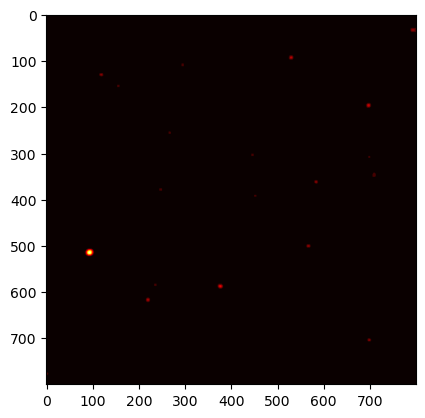

In [61]:
coords, roi_sizes, _ = peak_detection(img, thresh_abs=30, num_peaks=3)

plt.imshow(img, cmap='hot')
for i in range(len(coords)):
    print(coords[i])
    print(roi_sizes[i])
    print('')
    plt.scatter(coords[i][1], coords[i][0])
    pass

In [38]:
import numpy as np
from scipy import ndimage as ndi
import cv2

def peak_detection(img, prev_frames=None, binary_mask=None, testmode=False, exinfo=None,
                        presetROIsize=None, min_dist=30, thresh_abs=20, num_peaks=10, smoothing_radius=2, 
                        border_limit=15, init_smooth=1):
    """
    Common parameters:
    img - current image,
    prev_frames - previous image(s)
    binary_mask - binary mask of the region to consider
    testmode - to return preprocessed image or not
    exinfo - pandas dataframe of the detected vesicles and their track ids from the previous frames

    Pipeline specific parameters:
    min_dist - minimum distance in pixels between two peaks
    thresh_abs - low intensity threshold in img_ana of the peaks to consider
    num_peaks - number of peaks to track
    smoothing_radius - diameter of Gaussian smoothing of img_ana, in pixels
    ensure_spacing - to ensure spacing between detected peaks or not (bool 0/1)
    border_limit - how much of the border to remove peaks from in pixels
    init_smooth - if to perform an initial smoothing of the raw image or not (bool 0/1)
    """
    roi_sizes = False

    if binary_mask is None or np.shape(binary_mask) != np.shape(img):
        binary_mask = np.ones(np.shape(img)).astype('uint16')

    img = np.array(img).astype('float32')
    if prev_frames is not None and len(prev_frames) != 0:
        prev_frame = np.array(prev_frames[0]).astype('float32')
    else:
        prev_frame = np.zeros(np.shape(img)).astype('float32')
    if init_smooth==1:
        img = ndi.gaussian_filter(img, smoothing_radius)
        prev_frame = ndi.gaussian_filter(prev_frame, smoothing_radius)

    # multiply with binary mask
    img_ana = img * np.array(binary_mask)

    # Peak_local_max as a combo of opencv and numpy
    size = int(2 * min_dist + 1)
    img_ana = np.clip(img_ana, a_min=0, a_max=None)
    img_ana = img_ana.astype('float32')
    # get filter structuring element
    footprint = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=[size,size])
    # maximum filter (dilation + equal)
    image_max = cv2.dilate(img_ana, kernel=footprint)
    mask = np.equal(img_ana, np.array(image_max))
    mask &= np.greater(img_ana, thresh_abs)
    
    # get coordinates of peaks
    coordinates = np.nonzero(mask)
    intensities = img_ana[coordinates]
    # highest peak first
    idx_maxsort = np.argsort(-intensities)
    coordinates = tuple(arr for arr in coordinates)
    coordinates = np.transpose(coordinates)[idx_maxsort]

    # remove everything on the border (takes ~2-3ms if there are a lot of detected coordinates, but usually this is not the case)
    imsize = np.shape(img)[0]
    idxremove = []
    for idx, coordpair in enumerate(coordinates):
        if coordpair[0] < border_limit or coordpair[0] > imsize - border_limit or coordpair[1] < border_limit or coordpair[1] > imsize - border_limit:
            idxremove.append(idx)
    coordinates = np.delete(coordinates,idxremove,axis=0)

    # remove everyhting down to a certain length
    if len(coordinates) > num_peaks:
        coordinates = coordinates[:int(num_peaks),:]

    if not presetROIsize:
        roi_sizes = [[2.0, 2.0] for _ in coordinates]  # TODO: fake as of now

    if testmode:
        return coordinates, roi_sizes, exinfo, img_ana
    else:
        return coordinates, roi_sizes, exinfo


In [2]:
### Delete windows and MFX datasets

meas = a.active_measurement()
meas.activate(meas.configuration('ov conf'))

In [4]:
meas.configuration_names()

['mfx', 'ov conf', 'ov bm', 'config31', 'config55', 'config101', 'config152']

In [5]:
meas.stack_names()

['etFOV {0}',
 'Overview {100}',
 'FluorophoreConcCheck {54}',
 'DetectedEvents',
 'MF(240424-173730_ROI0-Pos[118,191]-Size[1.00,1.00]-RecTime[24.0s]-Cycle[0])/density/loc',
 'MF(240424-173800_ROI0-Pos[118,191]-Size[1.00,1.00]-RecTime[24.0s]-Cycle[1])/density/loc',
 'MF(240424-173831_ROI0-Pos[118,191]-Size[1.00,1.00]-RecTime[24.0s]-Cycle[2])/density/loc',
 'MF(240424-173902_ROI0-Pos[118,191]-Size[1.00,1.00]-RecTime[24.0s]-Cycle[3])/density/loc',
 'MF(240424-173932_ROI0-Pos[118,191]-Size[1.00,1.00]-RecTime[24.0s]-Cycle[4])/density/loc',
 'MF(240424-174003_ROI0-Pos[118,191]-Size[1.00,1.00]-RecTime[24.0s]-Cycle[5])/density/loc',
 'MF(240424-174034_ROI0-Pos[118,191]-Size[1.00,1.00]-RecTime[24.0s]-Cycle[6])/density/loc',
 'MF(240424-174104_ROI0-Pos[118,191]-Size[1.00,1.00]-RecTime[24.0s]-Cycle[7])/density/loc',
 'MF(240424-174135_ROI0-Pos[118,191]-Size[1.00,1.00]-RecTime[24.0s]-Cycle[8])/density/loc',
 'MF(240424-174205_ROI0-Pos[118,191]-Size[1.00,1.00]-RecTime[24.0s]-Cycle[9])/density/loc'

In [9]:
meas.activate(meas.configuration('config31'))

In [10]:
a.measurement_names()

['240424-174306_minflux']

In [11]:
meas.number_of_configurations()

7

In [12]:
meas.number_of_stacks()

15

In [ ]:
meas.